<a href="https://colab.research.google.com/github/CosmoStat/jax-lensing/blob/master/papers/Remy2021/IntroductionToScoreMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Denoising Score Matching

Authors:
- [@b-remy](https://github.com/b-remy) (Benjamin Remy)
- [@EiffL](https://github.com/EiffL) (Francois Lanusse)

## Overview

This notebook presents a short introduction to Denoising Score Matching as used
in Remy et al. 2021 (in prep.)



In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


## Creating a test density

For the purpose of this notebook, our test density is going to be the two moons
distribution.

In [2]:
#@title [Run me]
import seaborn as sns

dens_cmap = sns.cubehelix_palette(start=2.9, rot=0., dark=0.25, light=1., as_cmap=True)


def get_two_moons(sigma, resolution=1024):
    """
    Returns two moons distribution as a TFP distribution
    Parameters
    ----------
    sigma: float
    Spread of the 2 moons distribution.
    resolution: int
    Number of components in the gaussian mixture approximation of the
    distribution (default: 1024)
    Returns
    -------
    distribution: TFP distribution
    Two moon distribution
    """

    outer_circ_x = np.cos(np.linspace(0, np.pi, resolution))
    outer_circ_y = np.sin(np.linspace(0, np.pi, resolution))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, resolution))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, resolution)) - .5

    X = np.append(outer_circ_x, inner_circ_x)
    Y = np.append(outer_circ_y, inner_circ_y)
    coords = np.vstack([X,Y]).astype('float32')

    distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution).astype('float32')/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
    )
    return distribution

def display_score_two_moons(score, distribution, dpi=100, n=28):
    xc,yc = jnp.meshgrid(jnp.linspace(-1.5,2.5,204),jnp.linspace(-1.,1.5,128))
    Z = jnp.stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
    S = distribution.log_prob(Z)
    plt.figure(dpi=dpi)
    plt.imshow(jnp.exp(S.reshape((128,204))), cmap=dens_cmap, origin='lower')

    X = jnp.linspace(-1.5, 2.5, n)
    Y = jnp.linspace(-1., 1.5, n)

    points = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))

    res = score(points)

    g = res.reshape([n, n, 2])

    _x = jnp.linspace(0, 204, n)
    _y = jnp.linspace(0, 128, n)
    plt.quiver(_x, _y, g[:,:,0], g[:,:,1])
    plt.axis('off')

In [3]:
two_moons = get_two_moons(sigma=0.05) # Instantiates a TFP distribution object
two_moons

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[2] dtype=float32>

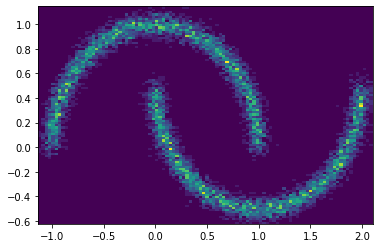

In [4]:
samples = two_moons.sample(10000, seed=jax.random.PRNGKey(1)) # Sample from distribution
hist2d(samples[:,0], samples[:,1], 100);

We can now compute the score field for this density using jax:

In [5]:
score = jax.vmap(jax.grad(two_moons.log_prob))

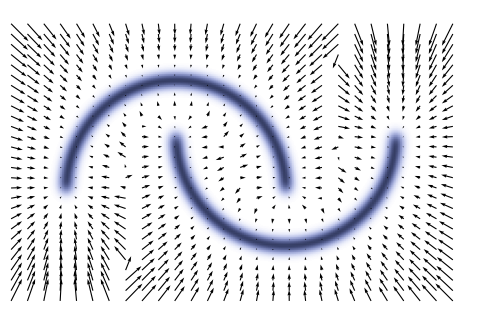

In [6]:
display_score_two_moons(score, two_moons)

savefig('two_moons_score.png', transparent=True, bbox_inches='tight',
        pad_inches = 0)